In [1]:
import xpress as xp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyreadr import read_r
from scipy.interpolate import interp1d
from param_watervalues import Reservoir
from time import time
from random import randint, seed

In [2]:
%load_ext line_profiler

In [3]:
%matplotlib widget

In [4]:
xp.controls.outputlog = 0
xp.controls.threads = 1
xp.controls.scaling = 0
xp.controls.presolve = 0
xp.controls.feastol = 1.e-7
xp.controls.optimalitytol = 1.e-7
xp.setOutputEnabled(False)

In [5]:
study_path = "D:/Users/gerbauxjul/Documents/6-Etudes Antares/ERAA_scandinavie"
output_path = study_path+"/user/fast_fi00"
# study_path = "D:/Users/gerbauxjul/Documents/6-Etudes Antares/OneNodeBase"
# output_path = study_path+"/user"

In [6]:
def retrieve_problem(year,week,output_path,itr=1):
    model = xp.problem()
    # f = open(output_path+f"/logs_xpress/read.log", "a")
    # model.setlogfile(output_path+f"/logs_xpress/read.log")
    model.controls.xslp_log = -1
    model.controls.lplogstyle = 0
    model.read(output_path+f"/problem-{year}-{week}--optim-nb-{itr}.mps")
    return(model)

In [7]:
S = 5
NTrain = 1
H = 168

In [8]:
def create_weekly_problem_itr(k,s,output_path, reservoir, pen_low, pen_high,pen_final):
    model = retrieve_problem(k+1,s+1,output_path)
    

    cst = model.getConstraint()
    binding_id = [i for i in range(len(cst)) if "WeeklyWaterAmount" in cst[i].name]

    model_copy = model.copy()

    x_s = xp.var("x_s",lb = 0, ub = reservoir.capacity)
    model_copy.addVariable (x_s)          # State at the begining of the current week

    x_s_1 = xp.var("x_s_1",lb = 0, ub = reservoir.capacity)
    model_copy.addVariable (x_s_1) # State at the begining of the following week

    U = xp.var("u",lb = -reservoir.P_pump[7*s]*reservoir.efficiency*H, ub = reservoir.P_turb[7*s]*H)
    model_copy.addVariable (U) # State at the begining of the following week

    model_copy.addConstraint(x_s_1 <= x_s - U + reservoir.inflow[s,k]*H)

    y = xp.var("y")

    model_copy.addVariable (y)    # Penality for violating guide curves

    if s!=S-1:
        model_copy.addConstraint(y >=  -pen_low* (x_s_1 - reservoir.Xmin[s]))
        model_copy.addConstraint(y >=  pen_high* (x_s_1 - reservoir.Xmax[s]))
    else :
        model_copy.addConstraint(y >=  -pen_final* (x_s_1 - reservoir.Xmin[s]))
        model_copy.addConstraint(y >=  pen_final* (x_s_1 - reservoir.Xmax[s]))

    model_copy.chgmcoef(binding_id,[U],[-1])
    model_copy.chgrhs(binding_id,[0])

    z = xp.var("z",lb = float('-inf'), ub =  float('inf'))

    model_copy.addVariable (z) # Auxiliar variable to introduce the piecewise representation of the future cost

    model_copy.chgobj([y,z], [1,1])

    return([model,binding_id, model_copy,x_s,x_s_1, z, y])
    

In [9]:
def modify_weekly_problem_itr(model,binding_id,u):

    model.chgrhs(binding_id,[u])

    model.lpoptimize()

    if model.attributes.lpstatus==1:
        beta = model.getObjVal()
        lamb = model.getDual(binding_id)[0]
        return(beta,lamb,model.attributes.SIMPLEXITER, model.attributes.TIME)
    else :
        raise(ValueError)

In [10]:
def calculate_VU(reward, reservoir,X,U, pen_low, pen_high, pen_final):
    V = np.zeros((len(X), S+1, NTrain))

    for s in range(S-1,-1,-1):#
        
        if s==S-1:
            pen = interp1d([0,reservoir.Xmin[s],reservoir.Xmax[s],reservoir.capacity],[-pen_final*(reservoir.Xmin[s]),0,0,-pen_final*(reservoir.capacity-reservoir.Xmax[s])])
        else :
            pen = interp1d([0,reservoir.Xmin[s],reservoir.Xmax[s],reservoir.capacity],[-pen_low*(reservoir.Xmin[s]),0,0,-pen_high*(reservoir.capacity-reservoir.Xmax[s])])

        for k in range(NTrain):
            V_fut = interp1d(X, V[:, s+1,k])
            Gs = lambda x: min([reward[i][s,k,0]*x+reward[i][s,k,1] for i in range(len(reward))])
            for i in range(len(X)):
                Vu = float('-inf')

                for i_fut in range(len(X)):
                    u = -X[i_fut] + X[i] + reservoir.inflow[s,k]*H
                    if -reservoir.P_pump[7*s]*H <= u <= reservoir.P_turb[7*s]*H:
                        G = Gs(u)
                        penalty = pen(X[i_fut])
                        if (G + V[i_fut, s+1,k]+penalty) > Vu:
                            Vu = G + V[i_fut, s+1,k]+penalty

                for u in range(len(U[s][k])):
                    state_fut = min(reservoir.capacity,X[i] - U[s][k][u] + reservoir.inflow[s,k]*H) 
                    if 0 <= state_fut :
                        penalty = pen(state_fut)
                        G = Gs(U[s][k][u])
                        if (G + V_fut(state_fut)+penalty) > Vu:
                            Vu = (G + V_fut(state_fut)+penalty)

                Umin = X[i]+ reservoir.inflow[s,k]*H-reservoir.Xmin[s]
                if -reservoir.P_pump[7*s]*H <= Umin <= reservoir.P_turb[7*s]*H:
                    state_fut = X[i] - Umin + reservoir.inflow[s,k]*H
                    penalty = pen(state_fut)
                    if (Gs(Umin) + V_fut(state_fut)+penalty) > Vu:
                        Vu = Gs(Umin) + V_fut(state_fut)+penalty

                Umax = X[i]+ reservoir.inflow[s,k]*H-reservoir.Xmax[s]
                if -reservoir.P_pump[7*s]*H <= Umax <= reservoir.P_turb[7*s]*H:
                    state_fut = X[i] - Umax + reservoir.inflow[s,k]*H 
                    penalty = pen(state_fut)
                    if (Gs(Umax) + V_fut(state_fut)+penalty) > Vu:
                        Vu = Gs(Umax) + V_fut(state_fut)+penalty
            
                V[i, s, k] = Vu + V[i,s,k]
        V[:,s,:] = np.repeat(np.mean(V[:,s,:],axis=1,keepdims=True),NTrain,axis=1)
    return np.mean(V,axis=2)

In [11]:
def filter_coeff(G, lb=-np.inf,ub=np.inf):
    G = np.reshape(np.concatenate(G),(len(G),2))
    idx = np.ones(len(G), dtype=bool)
    if len(G)>=2:
        m = xp.problem()
        m.controls.xslp_log = -1
        x = xp.var(lb=lb,ub=ub)
        y = xp.var(lb=-xp.infinity,ub=xp.infinity)
        m.addVariable(x,y)
        m.setObjective (y, sense=xp.maximize)
        
        for j in range(len(G)):
            for k in range(len(G)):
                if k!=j and idx[k]:
                    m.addConstraint(y<=(G[j,0]-G[k,0])*x+G[j,1]-G[k,1])
            if m.attributes.rows>=1:
                m.lpoptimize()
                if m.getObjVal()<0:
                    idx[j] = False
                m.delConstraint(range(0,m.attributes.rows))
        G = G[idx]
        # G = G[np.lexsort((G[:, 1], G[:, 0]))]

        # if np.isfinite(lb):
        #     y_lb = G[:,0]*lb+G[:,1]
        #     G = G[(y_lb[::-1]==np.maximum.accumulate(y_lb[::-1]))[::-1]]

        # if np.isfinite(ub):
        #     y_ub = G[:,0]*ub+G[:,1]
        #     G = G[(y_ub==np.maximum.accumulate(y_ub))]
        #     # G = np.concatenate((G,np.array([[0,G[-1,0]*ub+G[-1,1]]])))
        #     # G = G[np.lexsort((G[:, 1], G[:, 0]))]

        G = np.unique(G,axis=0)
    return(G)

In [12]:
def legendre(A,lb=-np.inf,ub=np.inf):
    coeff = [((A[i,1]-A[i+1,1])/(A[i+1,0]-A[i,0]),(A[i,0]*A[i+1,1]-A[i+1,0]*A[i,1])/(A[i+1,0]-A[i,0])) for i in range(len(A)-1)]
    if np.isfinite(lb):
        coeff.append((lb,-A[0,0]*lb-A[0,1]))
    elif A[0,0]>0:
        raise ValueError
    if np.isfinite(ub):
        coeff.append((ub,-A[-1,0]*ub-A[-1,1]))
    elif A[-1,0]<0:
        raise ValueError
    coeff = filter_coeff(np.array(coeff))
    return(coeff)

In [13]:
def add(A,B):
    res = np.array([(i[0]+j[0],i[1]+j[1]) for i in A for j in B])
    res = filter_coeff(res)
    return(res)

In [14]:
def transform(V, apport):
    res = V
    res[:,1] = V[:,0]*apport+V[:,1]
    return(res)

In [15]:
def calculate_VU_continu(reward, reservoir, X, U, pen_low, pen_high):
    V = [np.zeros((1,2)) for s in range(S+1)]

    for s in range(S-1,-1,-1):#
        Vu = np.zeros((1,2))
        for k in range(NTrain):
            G = [-reward[i][s,k] for i in range(len(reward))]
            V_fut = transform(V[s+1], reservoir.inflow[s,k]*H)
            
            G = filter_coeff(G,-reservoir.P_pump[7*s]*H,reservoir.P_turb[7*s]*H)
            V_fut = filter_coeff(V_fut,0,reservoir.capacity)

            G_etoile = legendre(G,-reservoir.P_pump[7*s]*H,reservoir.P_turb[7*s]*H)
            V_fut_etoile = legendre(V_fut,0,reservoir.capacity)
                
            Vu_etoile = add(G_etoile,V_fut_etoile)
            Vu = add(Vu,legendre(Vu_etoile))
        V[s] = filter_coeff(Vu/NTrain,0,reservoir.capacity)

                
    return V

In [16]:
def compute_x(reservoir,X,U,V,reward,pen_low,pen_high, pen_final, itr):
    initial_x = [reservoir.initial_level]
    controls = np.zeros((S,NTrain))
    cout = 0
    seed(19*itr)
    
    for s in range(S):
        cout_s =0
        V_fut = interp1d(X, V[:, s+1])
        k = randint(0,NTrain-1)
        
        if s==S-1:
            pen = interp1d([0,reservoir.Xmin[s],reservoir.Xmax[s],reservoir.capacity],[-pen_final*(reservoir.Xmin[s]),0,0,-pen_final*(reservoir.capacity-reservoir.Xmax[s])])
        else :
            pen = interp1d([0,reservoir.Xmin[s],reservoir.Xmax[s],reservoir.capacity],[-pen_low*(reservoir.Xmin[s]),0,0,-pen_high*(reservoir.capacity-reservoir.Xmax[s])])
        Gs = lambda x: min([reward[i][s,k,0]*x+reward[i][s,k,1] for i in range(len(reward))])

        Vu = float('-inf')

        for i_fut in range(len(X)):
            u = -X[i_fut] + initial_x[-1] + reservoir.inflow[s,k]*H
            if -reservoir.P_pump[7*s]*H <= u <= reservoir.P_turb[7*s]*H:
                G = Gs(u)
                penalty = pen(X[i_fut])
                if (G + V[i_fut, s+1]+penalty) > Vu:
                    Vu = G + V[i_fut, s+1]+penalty
                    xf = X[i_fut]
                    cout_s = G

        for u in range(len(U[s][k])):
            state_fut = min(reservoir.capacity,initial_x[-1] - U[s][k][u] + reservoir.inflow[s,k]*H) 
            if 0 <= state_fut :
                penalty = pen(state_fut)
                G = Gs(U[s][k][u])
                if (G + V_fut(state_fut)+penalty) > Vu:
                    Vu = (G + V_fut(state_fut)+penalty)
                    xf = state_fut
                    cout_s =G

        Umin = initial_x[-1]+ reservoir.inflow[s,k]*H-reservoir.Xmin[s]
        if -reservoir.P_pump[7*s]*H <= Umin <= reservoir.P_turb[7*s]*H:
            state_fut = initial_x[-1] - Umin + reservoir.inflow[s,k]*H
            penalty = pen(state_fut)
            if (Gs(Umin) + V_fut(state_fut)+penalty) > Vu:
                Vu = Gs(Umin) + V_fut(state_fut)+penalty
                xf = state_fut
                cout_s = Gs(Umin)

        Umax = initial_x[-1]+ reservoir.inflow[s,k]*H-reservoir.Xmax[s]
        if -reservoir.P_pump[7*s]*H <= Umax <= reservoir.P_turb[7*s]*H:
            state_fut = initial_x[-1] - Umax + reservoir.inflow[s,k]*H 
            penalty = pen(state_fut)
            if (Gs(Umax) + V_fut(state_fut)+penalty) > Vu:
                Vu = Gs(Umax) + V_fut(state_fut)+penalty
                xf = state_fut
                cout_s = Gs(Umax)

        initial_x.append(xf)
        controls[s] = -(initial_x[s+1]-initial_x[s]-reservoir.inflow[s,k]*H)
        cout += cout_s
    return(initial_x, controls, cout)

In [17]:
def compute_upper_bound(reservoir,list_models,X,V, hot_start):
    cout = 0
    controls = np.zeros((S,NTrain))
    weekly_cost = np.zeros((S,NTrain))
    for k in range(NTrain):

        rstatus = []
        cstatus = []
        
        level_i = reservoir.initial_level
        for s in range(S):
            print(f"{k} {s}",end="\r")
            m = list_models[s][k]
            # Future cost: piecewise representation of the future cost
            nb_cons = m[2].attributes.rows
          

            for i in range(len(X)-1):
                if (V[i+1, s+1]<float('inf'))&(V[i, s+1]<float('inf')):
                    m[2].addConstraint(m[5] >= (V[i+1, s+1] - V[i, s+1]) / (X[i+1] - X[i]) * (m[4] - X[i]) + V[i, s+1])

            cst_initial_level = m[3] == level_i
            m[2].addConstraint(cst_initial_level)

            if (len(rstatus)!=0)&(hot_start):
                m[2].loadbasis(rstatus, cstatus)

            m[2].lpoptimize()

            if m[2].attributes.lpstatus==1:
                if hot_start:
                    m[2].getbasis(rstatus, cstatus)
                beta = m[2].getObjVal()
                xf = m[2].getSolution(m[4])
                z = m[2].getSolution(m[5])
                y = m[2].getSolution(m[6])
                m[2].delConstraint(range(nb_cons,m[2].attributes.rows))
                cout += beta
                controls[s,k]=-(xf-level_i-reservoir.inflow[s,k]*H)
                level_i = xf
                if s!=S-1:
                    cout += - z - y
                weekly_cost[s,k] = beta - z - y
            else :
                raise(ValueError)
    return(cout/NTrain, controls, weekly_cost)
            

In [18]:
def itr_control(reservoir:Reservoir, output_path, pen_low, pen_high,X, N, pen_final):

    tot_t = []
    debut = time()
    # seed(19)
    
    list_models = [[] for i in range(S)]
    for s in range(S):
        for k in range(NTrain):
            m = create_weekly_problem_itr(k=k,s=s,output_path=output_path,reservoir=reservoir,pen_low=pen_low,pen_high=pen_high,pen_final=pen_final)
            list_models[s].append(m)
    
    # controls = np.zeros((S,NTrain))
    # for k in range(NTrain):
    #     initial_x = [reservoir.initial_level]
    #     for s in range(S):
    #         xf = initial_x[-1] + max(reservoir.inflow[s,k]*H-reservoir.P_turb[7*s]*H,0)
    #         initial_x.append(xf)
    #         controls[s][k]=0#-(initial_x[s+1]-initial_x[s]-reservoir.inflow[s,k]*H)
    V = np.zeros((len(X), S+1))

    G = [np.zeros((S+1,NTrain,2))]
    U = [[[reservoir.P_turb[7*s]*H,-reservoir.P_pump[7*s]*H] for k in range(NTrain)] for s in range(S)]
    itr_tot = []
    

    best_cost = np.zeros(NTrain)
    # best_lb = np.zeros(NTrain)

    controls_upper = []

    rstatus = []
    cstatus = []

    traj = []

    # upper_bound, controls = compute_upper_bound(reservoir,list_models,X,V,pen_low,pen_high) 
    i = 0
    gap = 1e3
    fin = time()
    tot_t.append(fin-debut)
    while (gap>=1e-2 or gap<=-1e-3) and (i<3):
        debut = time()
        Gj = np.zeros((S+1,NTrain,2))
        current_cost = np.zeros(NTrain)
        current_itr = np.zeros((S,NTrain,3))
        # k = randint(0,NTrain-1)
        initial_x, controls, lb = compute_x(reservoir=reservoir,X=X,U=U,V=V,reward=G,pen_low=pen_low,pen_high=pen_high, pen_final=pen_final, itr=i)
        traj.append(np.array(initial_x))
        for k in range(NTrain):
            rstatus = []
            cstatus = []    
            # initial_x, controls, lb = compute_x(reservoir=reservoir,k=k,X=X,U=U,V=V,reward=G,pen_low=pen_low,pen_high=pen_high, pen_final=pen_final)
            # best_lb[k] = max(best_lb[k],-lb)
            for s in range(S):
                print(f"{k} {s}",end="\r")
                m = list_models[s][k]
                # if i == 1:
                    # m[0].controls.presolve = 0
                # m[0].controls.outputlog = 1
                # f = open(output_path+f"/logs_xpress/logfile-{i}-{k}-{s}.log", "w")
                # m[0].setlogfile(output_path+f"/logs_xpress/logfile-{i}-{k}-{s}.log")
                if (len(rstatus)!=0)&(i==0):
                    m[0].loadbasis(rstatus, cstatus)
                m[0].chgrhs(m[1],[controls[s][k]])
                debut_1 = time()
                m[0].lpoptimize()
                fin_1 = time()
                

                if m[0].attributes.lpstatus==1:
                    beta = m[0].getObjVal()
                    lamb = m[0].getDual(m[1])[0]
                    itr = m[0].attributes.SIMPLEXITER
                    t = m[0].attributes.TIME
                    if i==0:
                        m[0].getbasis(rstatus, cstatus)
                else :
                    raise(ValueError)
                # beta,lamb,itr, t = modify_weekly_problem_itr(model=m[0],binding_id=m[1],u=controls[s][k])
                
                Gj[s,k,0] = -lamb
                Gj[s,k,1] = -beta + lamb*controls[s][k]
                U[s][k].append(controls[s][k])
                current_cost[k] += beta
                current_itr[s,k] = (itr,t,fin_1-debut_1)
            # V = calculate_VU(reward=G+[Gj],reservoir=reservoir,X=X,U=U,pen_low=pen_low,pen_high=pen_high, pen_final=pen_final)
        G.append(Gj)
        itr_tot.append(current_itr)

        # V = calculate_VU_continu(reward=G,reservoir=reservoir,X=X,U=U,pen_low=pen_low,pen_high=pen_high)
        
        # V0_continu = max([V[0][i,0]*reservoir.initial_level+V[0][i,1] for i in range(len(V[0]))])

        V = calculate_VU(reward=G,reservoir=reservoir,X=X,U=U,pen_low=pen_low,pen_high=pen_high, pen_final=pen_final)
        V_fut = interp1d(X, V[:, 0])
        V0 = V_fut(reservoir.initial_level)

        if np.mean(best_cost)==0:
            best_cost = current_cost
        else :
            best_cost = np.minimum(best_cost,current_cost)

        if i==0:
            hot_start = True
        else :
            hot_start = False
        upper_bound, controls, weekly_cost = compute_upper_bound(reservoir,list_models,X,-V, hot_start=hot_start)

        # upper_bound = np.mean(best_cost) 
        controls_upper.append(controls)
        gap = upper_bound+V0
        print(gap, upper_bound,-V0,np.mean(best_cost)) #,V0_continu)
        gap = gap/-V0
        i+=1
        fin = time()
        tot_t.append(fin-debut)
    return (V, G, np.array(itr_tot),tot_t, U, controls_upper, traj, weekly_cost)

In [19]:
pen_low = 10000
pen_high = 0
pen_final = 10000

In [20]:
reservoir = Reservoir(5530000,1,study_path,"fi00","reservoir")
# reservoir = Reservoir(1e7,1,study_path,"area","reservoir", final_level=True)

In [21]:
xNsteps = 20
X = np.linspace(0, reservoir.capacity, num = xNsteps)

In [24]:
vb, G, itr, temps_tot, U, controls_upper, traj, weekly_cost = itr_control(reservoir, output_path, pen_low, pen_high, X,2, pen_final) 
# 6m6s cas simple pour 20 niveaux de stock
# 9m0s cas simple pour 50 niveaux de stock 4 itérations
# 86m pour 50 niveaux de stock eraa_scandinavie 10-20 min récupération pb puis 3 itérations (1 simu avec Antares prend 9 minutes > ici c'est plus long)

58879405.36824179 536900041.501341 478020636.1330992 631862262.6692457
2.384185791015625e-07 536900041.501341 536900041.5013407 536900041.5013407


In [91]:
np.sum(weekly_cost)

4046855860.4306197

In [92]:
total = 0
k = 0
for s in range(S):
    Gs = lambda x: min([G[i][s,k,0]*x+G[i][s,k,1] for i in range(len(G))])
    total += Gs(controls_upper[-1][s][k])
print(-total)

4036779264.0492673


In [93]:
i = np.argmax([X>=reservoir.initial_level])
j = np.argmin([X<=reservoir.initial_level])
vb[i-1:j+1,0]

array([-4.01549984e+09, -4.01438856e+09])

In [23]:
itr[:,0,0,:] # Dual

array([[1.63000000e+04, 1.00000000e+00, 9.74396706e-01],
       [1.32400000e+03, 0.00000000e+00, 2.95212507e-01],
       [0.00000000e+00, 0.00000000e+00, 1.19680405e-01]])

In [24]:
[np.sum(itr[i,:,:,2]) for i in range(len(itr))]

[187.14149737358093, 68.00859761238098, 51.747801065444946]

In [25]:
[np.mean(itr[i,:,:,0]) for i in range(len(itr))]

[3075.130769230769, 673.1, 501.9365384615385]

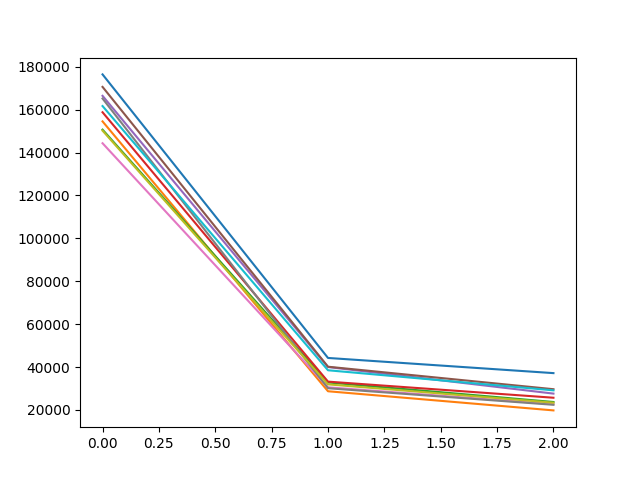

In [73]:
plt.figure() # Dual
for k in range(NTrain):
    plt.plot(np.arange(len(itr)),np.sum(itr[:,:,k,0],axis=1))

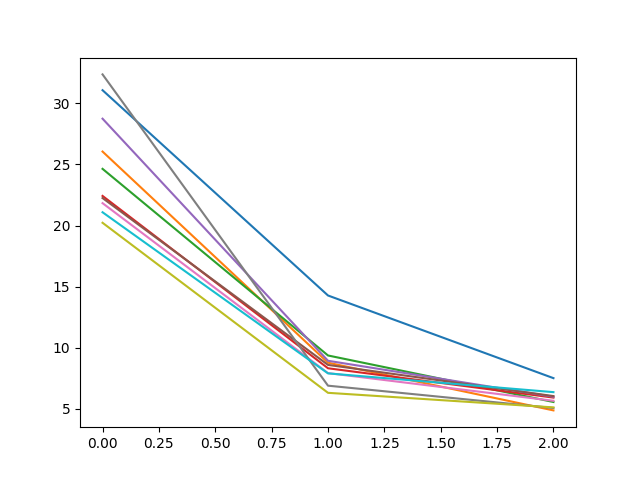

In [74]:
plt.figure() # Dual
for k in range(NTrain):
    # plt.plot(np.arange(len(itr)),np.sum(itr[:,:,k,1],axis=1))
    plt.plot(np.arange(len(itr)),np.sum(itr[:,:,k,2],axis=1))

C:\Users\gerbauxjul\AppData\Local\Temp\ipykernel_8752\475351886.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(np.ravel(itr[i,:,:,0]),np.ravel(itr[i,:,:,2]/itr[i,:,:,0]), label=f"Itération {i}")


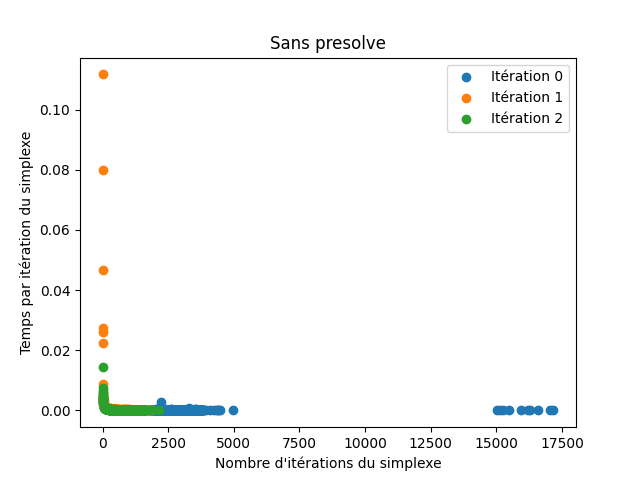

In [75]:
plt.figure() # Dual
plt.title("Sans presolve")
for i in range(len(itr)):
    plt.scatter(np.ravel(itr[i,:,:,0]),np.ravel(itr[i,:,:,2]/itr[i,:,:,0]), label=f"Itération {i}")
plt.xlabel("Nombre d'itérations du simplexe")
plt.ylabel("Temps par itération du simplexe")
plt.legend()

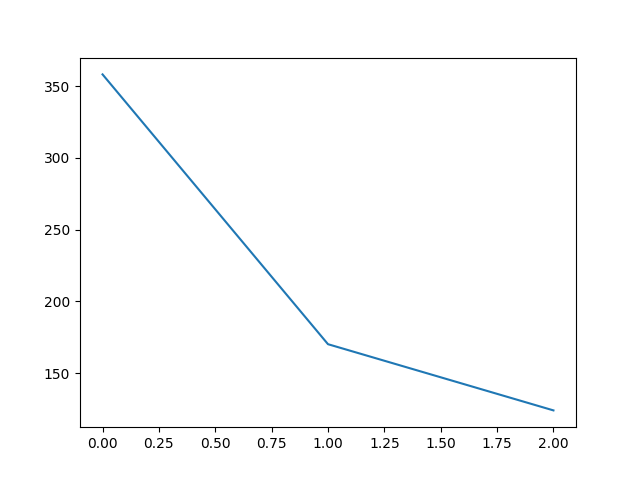

In [91]:
plt.figure() # Dual
plt.plot(temps_tot[1:])
# plt.plot(np.sum(np.sum(itr[:,:,:,1],axis=1),axis=1))
# plt.plot(np.sum(np.sum(itr[:,:,:,2],axis=1),axis=1))

In [26]:
temps_tot[0]

491.76038646698

In [27]:
sum(temps_tot[1:])

346.0274906158447

In [28]:
sum(np.ravel(itr[:,:,:,2]))

306.89789605140686

In [29]:
sum(np.ravel(itr[:,:,:,0]))

2210087.0

In [95]:
np.unravel_index(np.argmin(itr[:,:,:,0]),itr[:,:,:,0].shape)

(2, 0, 0)

In [96]:
itr[:,2,0,:]

array([[3.82800000e+03, 1.00000000e+00, 6.81129932e-01],
       [1.15200000e+03, 1.00000000e+00, 3.26288700e-01],
       [1.23100000e+03, 1.00000000e+00, 4.21144485e-01]])

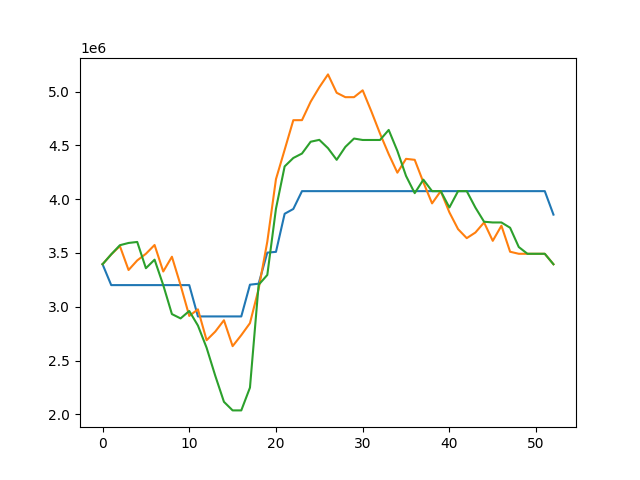

In [97]:
plt.figure()
for i in range(len(traj)):
    plt.plot(traj[i])


In [64]:
%lprun -f itr_control res=itr_control(reservoir, output_path, pen_low, pen_high, X,2, pen_final)

202443011.91553283 1020266146.8503457 817823134.9348129 0.0 1406283117.9562113
-54544.19377708435 1019665846.4830819 1019720390.676859 0.0 1077190942.4078531


Timer unit: 1e-07 s

Total time: 93.8743 s

Could not find file C:\Users\gerbauxjul\AppData\Local\Temp\ipykernel_20860\2010757685.py
Are you sure you are running this program from the same directory
that you ran the profiler from?
Continuing without the function's contents.

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           
     2                                           
     3                                           
     4                                           
     5         1        113.0    113.0      0.0  
     6        11        114.0     10.4      0.0  
     7        40        931.0     23.3      0.0  
     8        30  358869902.0    1e+07     38.2  
     9        30       1127.0     37.6      0.0  
    10                                           
    11                                           
    12                                           
    13                                           
    14     

# Results

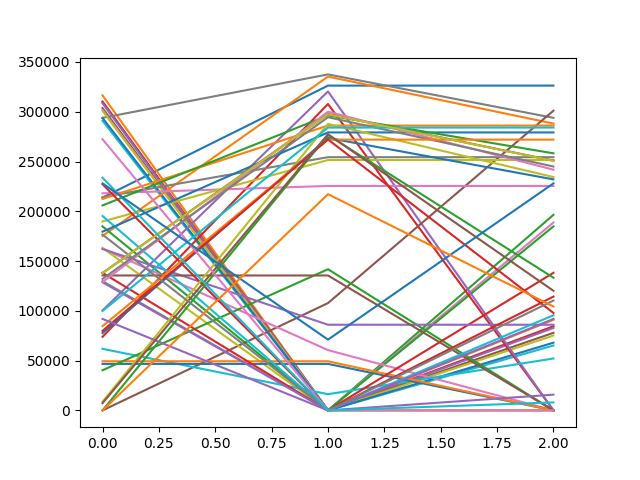

In [66]:
plt.figure()
for s in range(S):
    plt.plot(U[s][0][2:])

In [67]:
penalties = np.zeros((xNsteps, S+1))
for s in range(S+1):
    pen = interp1d([0,reservoir.Xmin[s],reservoir.Xmax[s],reservoir.capacity],[-pen_low*(reservoir.Xmin[s]),0,0,-pen_high*(reservoir.capacity-reservoir.Xmax[s])])
    for i in range(xNsteps):
        penalties[i,s] = pen(X[i])

In [68]:
s = 10

In [69]:
i = np.argmax([X>=reservoir.Xmin[s]])
j = np.argmin([X<=reservoir.Xmax[s]])
# i = 0
# j = xNsteps

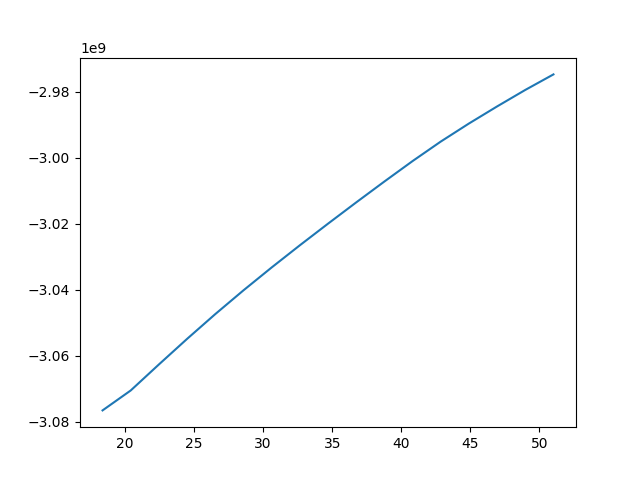

In [70]:
plt.figure()
plt.plot(X[i:j]/reservoir.capacity*100,vb[i:j,s])#-penalties[i:j,s]

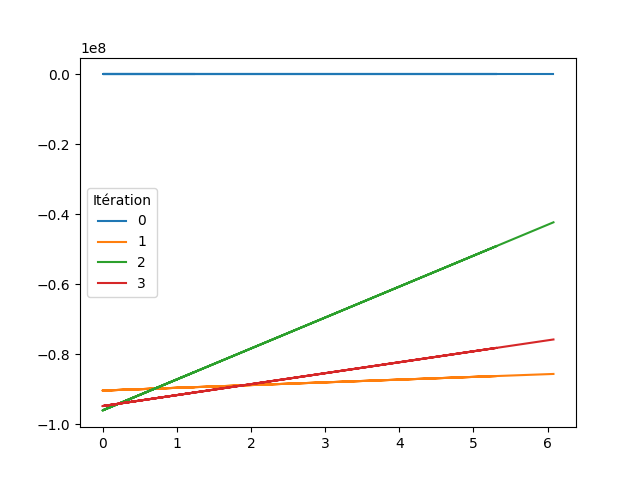

In [71]:
plt.figure()
for k in range(len(G)):
    g = G[k][s,0,0]*np.array(U[s][0])+G[k][s,0,1]
    plt.plot(np.array(U[s][0])/reservoir.capacity*100,g,label=f"{k}")#-penalties[i:j,s]
plt.legend(title="Itération")

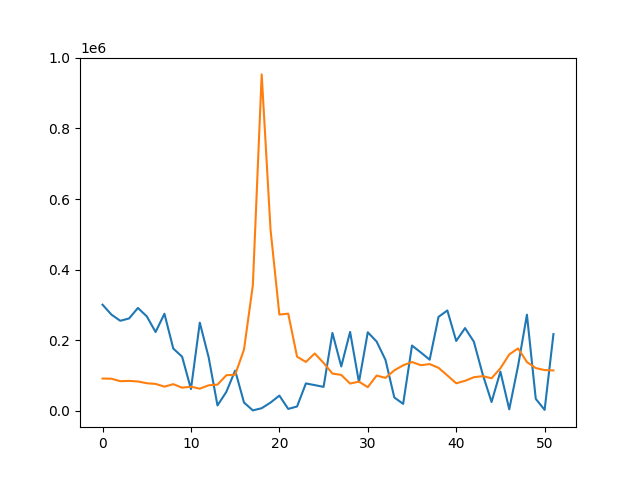

In [72]:
plt.figure()
i = 0
k = 0
plt.plot(np.array(controls_upper)[i,:,k])
plt.plot([reservoir.inflow[s,k]*H for s in range(S)])

In [73]:
trajectoires = np.zeros_like(np.array(controls_upper))
for i in range(len(controls_upper)):
    for s in range(S):
        for k in range(NTrain):
            if s==0:
                trajectoires[i,s,k] = reservoir.initial_level - np.array(controls_upper)[i,s,k]+reservoir.inflow[s,k]*H
            else :
                trajectoires[i,s,k] = trajectoires[i,s-1,k] - np.array(controls_upper)[i,s,k]+reservoir.inflow[s,k]*H

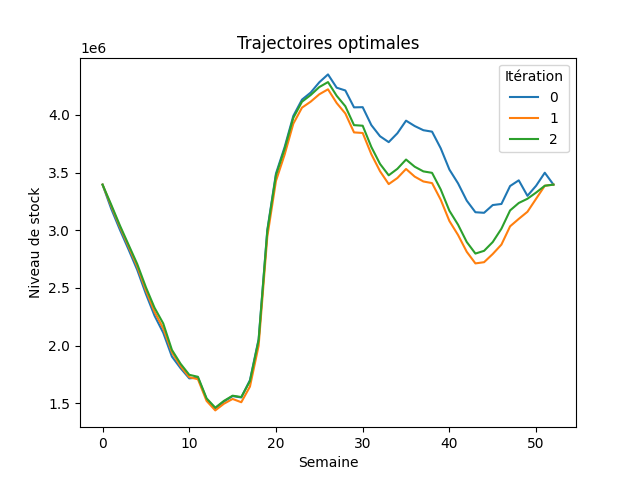

In [74]:
k = 0
plt.figure()
plt.title("Trajectoires optimales")
plt.xlabel("Semaine")
plt.ylabel("Niveau de stock")
for i in range(len(trajectoires)):
    plt.plot([reservoir.initial_level]+list(trajectoires[i,:,k]),label=f"{i}")
plt.legend(title="Itération")

In [42]:
reservoir.initial_level

3395420.0

In [43]:
reservoir.Xmax

array([4213860., 4081140., 3953950., 3837820., 3705100., 3583440.,
       3483900., 3306940., 3146570., 2997260., 2825830., 2676520.,
       2588040., 2604630., 2588040., 2930900., 3522610., 4097730.,
       4368700., 4451650., 4490360., 4617550., 4656260., 4623080.,
       4551190., 4628610., 4694970., 4766860., 4805570., 4822160.,
       4777920., 4761330., 4827690., 4849810., 4805570., 4772390.,
       4783450., 4838750., 4844280., 4855340., 4849810., 4800040.,
       4772390., 4722620., 4689440., 4645200., 4589900., 4562250.,
       4518010., 4484830., 4424000., 4213860., 4213860.])

# Antares Xpress

In [25]:
f = open("Z://JulietteG//6-Etutes_Antares//log_reso_xpress.txt","r")
lines = f.readlines()

In [26]:
len(lines)

5077

In [27]:
text = "".join(lines)

In [28]:
pbs = text.split("Optimal solution found")[1:]

In [29]:
len(pbs)

104

In [30]:
times = open("Z://JulietteG//6-Etutes_Antares//ERAA_scandinavie_v82//output//20240213-1216eco-xpress//optimization//week-by-week//year_0.txt","r").readlines()

In [31]:
itr_antares = np.zeros((2, 52, 3))

In [32]:
for i in range(len(pbs)):
    itr_antares[i%2, i//2, 0] = int(pbs[i].split("simplex iterations")[0].strip().split(" ")[-1])
    itr_antares[i%2, i//2, 1] = int(times[i//2+1].split(" ")[1+i%2])/1000
    itr_antares[i%2, i//2, 2] = float(pbs[i].split("Final objective")[1].split(":")[1].split("\n")[0].strip())

Text(0.5, 1.0, 'Première itération - année 1')

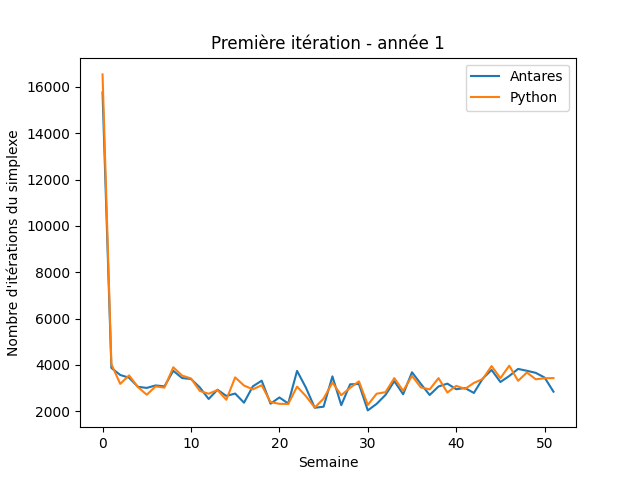

In [54]:
plt.figure()
for i in range(len(itr_antares)-1):
    plt.plot(itr_antares[i, :, 0], label=f"Antares")
for i in range(len(itr)):
    plt.plot(itr[i, :, :, 0], label=f"Python")
plt.legend()
plt.xlabel("Semaine")
plt.ylabel("Nombre d'itérations du simplexe")
plt.title("Première itération - année 1")

Text(0.5, 1.0, 'Première itération - année 1')

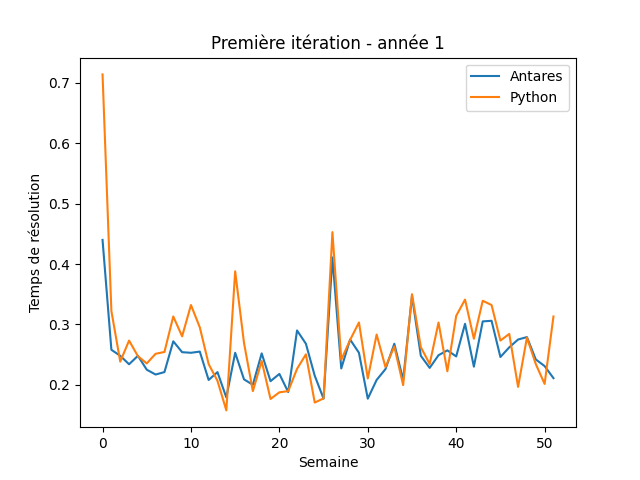

In [55]:
plt.figure()
for i in range(len(itr_antares)-1):
    plt.plot(itr_antares[i, :, 1], label=f"Antares")
for i in range(len(itr)):
    plt.plot(itr[i, :, :, 2], label=f"Python")
plt.legend()
plt.xlabel("Semaine")
plt.ylabel("Temps de résolution")
plt.title("Première itération - année 1")

Text(0.5, 1.0, 'Première itération - année 1')

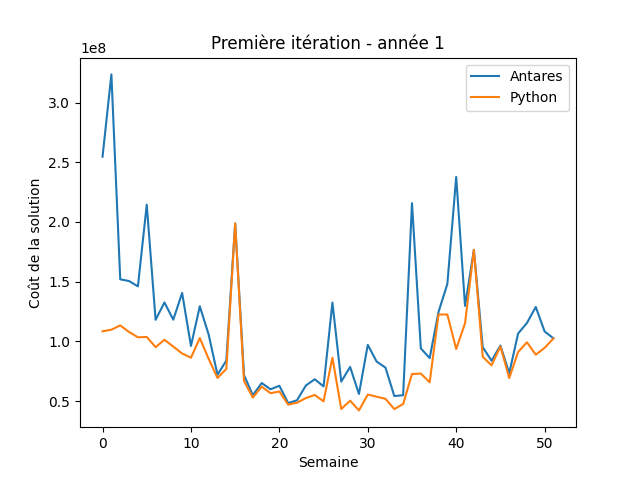

In [56]:
plt.figure()
for i in range(len(itr_antares)-1):
    plt.plot(itr_antares[i, :, 2], label=f"Antares")
for i in range(len(itr)):
    plt.plot([-G[i+1][s][0,1]- G[i+1][s][0,0]*U[s][0][-1] for s in range(S)], label=f"Python")
plt.legend()
plt.xlabel("Semaine")
plt.ylabel("Coût de la solution")
plt.title("Première itération - année 1")